# import deep learning libs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random

In [2]:
torch.__version__

'1.1.0'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## seed settings

In [4]:
torch.manual_seed(1)
random.seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [5]:
import os
import sys
import numpy as np

In [6]:
cwd = os.getcwd()

In [7]:
sys.version_info

sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0)

# Hyperparameter

In [8]:
EPOCH = 1
BATCH_SIZE = 128
LEARNING_RATE = 1e-3

# MNIST Data load

In [9]:
from mnist import *

In [10]:
mymnist = MyMNIST(BATCH_SIZE)

# Autoencoder settings

In [11]:
class CAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size= 3, stride= 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size= 3, stride= 2, padding = 1),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size= 3, stride= 2, padding = 1, output_padding= 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size= 3, stride= 1, padding = 1),
            nn.Sigmoid(),
        )
        
        
        
        
    def forward(self, x):
        '''
            torch.Size([1, 1, 28, 28])
            torch.Size([1, 16, 14, 14])
            torch.Size([1, 1, 28, 28])
        '''
        # print(x.size())
        encoder = self.encoder(x)
        # print(encoder.size())
        decoder = self.decoder(encoder)
        
        # print(decoder.size())
        return decoder

In [12]:
model = CAE().to(device)

In [13]:
model

CAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Sigmoid()
  )
)

In [14]:
model.encoder[0].weight.data[0] # init weights - check update weights

tensor([[[ 0.1718, -0.1471, -0.0646],
         [ 0.1565, -0.3138,  0.1999],
         [-0.0686,  0.1696,  0.0463]]])

In [15]:
# mymnist.mnist_train.train_data.shape

In [16]:
# x_test_input= torch.randn(1, 1, 28, 28).to(device)

In [17]:
# cae(x_test_input)

In [18]:
%%time
criterion = nn.MSELoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Wall time: 0 ns


# Train model

In [19]:
%%time
model.train()

total_batch = len(mymnist.train_data_loader)
print('Learning started. It takes sometime.')
for epoch in range(EPOCH):
    avg_cost = 0

    for X, Y in mymnist.train_data_loader:
        X = X.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, X)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.0117324367
Learning Finished!
Wall time: 1min 24s


# Test Model

In [20]:
out_img = torch.squeeze(hypothesis.cpu().data)
print(out_img.size())

torch.Size([128, 28, 28])


In [21]:
import matplotlib.pyplot as plt

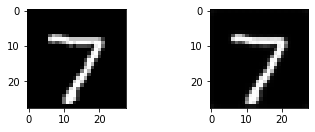

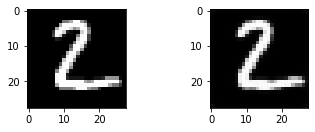

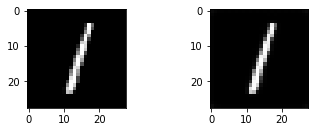

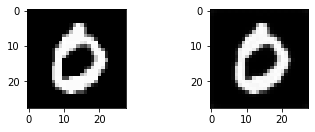

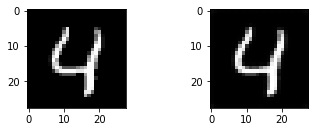

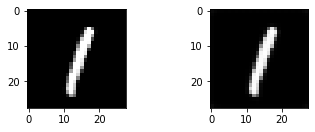

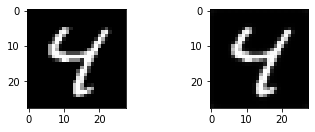

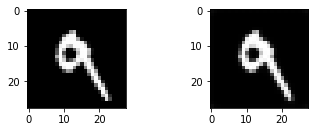

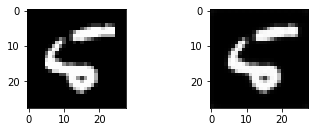

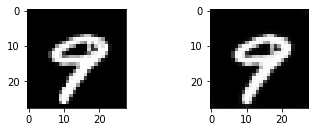

In [22]:
with torch.no_grad():
    model.eval()
    
    X_test = mymnist.mnist_test.data.view(len(mymnist.mnist_test), 1, 28, 28).float().to(device)
    X_test /= 255.  
        
    ae_result = model(X_test[:10])
    
    for i in range(len(ae_result)):
        fig = plt.figure()
        
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        
        ax1.imshow(X_test[i].cpu().numpy().squeeze(), cmap = 'gray')
        ax2.imshow(ae_result[i].cpu().numpy().squeeze(), cmap = 'gray')
        plt.show()
        
    

In [23]:
model.encoder[0].weight.data[0] # check update weights

tensor([[[ 0.2050, -0.1236, -0.0321],
         [ 0.2000, -0.2616,  0.2489],
         [-0.0308,  0.2175,  0.0853]]])

# Reuse encoder part for training CNN classifier

In [24]:
encoder = model.encoder

In [25]:
encoder

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
)

pretrained encoder weights 사용1

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size= 3, stride= 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size= 3, stride= 2, padding = 1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(14*14*16, 10)
        
    def forward(self, x):
        out = self.encoder(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [27]:
cnn_model = CNN().to(device)

In [28]:
cnn_dict = cnn_model.state_dict()
ae_net_dict = model.state_dict()

# 필터링 디코더 layers
ae_net_dict = {k: v for k, v in ae_net_dict.items() if k in cnn_dict}

# encoder layers overwrite
cnn_dict.update(ae_net_dict)
cnn_model.load_state_dict(cnn_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [29]:
cnn_model

CNN(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

encoder weights update후 사용2

In [30]:
class CNN(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        
        self.encoder = encoder
        self.fc = nn.Linear(14*14*16, 10)
        
    def forward(self, x):
        out = self.encoder(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [31]:
cnn_model = CNN(encoder).to(device)

In [32]:
cnn_model

CNN(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [33]:
cnn_model.encoder[0].weight.data[0] # check update weights

tensor([[[ 0.2050, -0.1236, -0.0321],
         [ 0.2000, -0.2616,  0.2489],
         [-0.0308,  0.2175,  0.0853]]])

In [34]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

# Train CNN Classifier

In [35]:
%%time
# train my model
total_batch = len(mymnist.train_data_loader)
model.train()    # set the model to train mode (dropout=True)
print('Learning started. It takes sometime.')
for epoch in range(EPOCH):
    avg_cost = 0

    for X, Y in mymnist.train_data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = cnn_model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.358680338
Learning Finished!
Wall time: 44.8 s


In [36]:
model.encoder[0].weight.data[0] # check update weights

tensor([[[ 0.2245, -0.1100, -0.0279],
         [ 0.2581, -0.2196,  0.2845],
         [ 0.0049,  0.2495,  0.1192]]])

# Test CNN Classifier

In [37]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)
    
    accuracy_true = 0
    for X, Y in mymnist.test_data_loader:
    
        X = X.to(device)
        Y = Y.to(device)

        prediction = cnn_model(X)
        correct_prediction = torch.sum(torch.argmax(prediction, 1) == Y)
        accuracy_true += correct_prediction
        
    print('Accuracy:', accuracy_true.item() / len(mymnist.mnist_test))

Accuracy: 0.9432
